# IMAGING mode dual scan under TMC control and monitoring

This notebook implements the following JAMA test case: [NB TMC -> Two consecutive scans with delay model correction](https://skaoffice.jamacloud.com/perspective.req#/testCases/1166398?projectId=335)

All tests under TMC control and monitoring are approached as black box tests, where no direct LOW CSP control is done.

This implementation performs a basic execution block consisting of 2 scans on two different targets operated through TMC, performing correlation on simulated noise input and capturing the visibility output from LOW CSP.  
**Note: the source delays in this notebook are supplied by TMC.**


Verification of observation sequence ([ADR-8](https://jira.skatelescope.org/browse/ADR-8))

Equivalent to subarray state:

- Assign resources: EMPTY -> RESOURCING -> IDLE
- Configure: IDLE -> CONFIGURING -> READY
- Scan: READY -> SCANNING -> READY
- Configure: READY -> CONFIGURING -> READY
- Scan: READY -> SCANNING -> READY
- End: READY -> IDLE
- Release resources: IDLE -> RESOURCING -> EMPTY


## Notebook setup


### Imports


In [1]:
import itertools
import json
import logging
import os
import pprint
import socket
import sys
import time
import typing
from datetime import datetime
from io import BytesIO

import pandas as pd
import tango
import xarray as xr
from IPython.display import Markdown, display, update_display
from matplotlib import pyplot as plt
from PIL import Image
from ska_control_model import AdminMode, ObsState

from ska_low_csp_test.cbf import visibilities
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.domain.spead import LowCbfSdpSpeadStationBaselineMapping
from ska_low_csp_test.synchronisation import wait_for_condition

### TANGO / Kubernetes settings

Change the settings below to point to the correct Kubernetes namespace and TANGO database.


In [2]:
TANGO_DB_PORT = 10000
TANGO_DB_SVC = "ska-low-csp-databaseds"
TANGO_DB_NAMESPACE = "ska-low-csp-dev"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

### Notebook settings

Change the settings below to change the notebook behaviour.


#### Settings that users may want to change for typical IMAGING mode


In [3]:
# allow any valid subarray id (at the moment fixed to 4 subarray): subarray_id = {1,2,3,4}
SUBARRAY_ID = 1

# - test with AA1 18 stations (IMAGING mode)
STATION_IDS = [345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 429, 430, 431, 432, 433, 434]  # AA1

# allow any valid number of channels
FREQUENCY_IDS = list(range(100, 108))

STATION_BEAM_ID = 1

#### Scan target coordinates


In [4]:
COORD_a = {"reference_frame": "ICRS", "c1": 180.0, "c2": 50.0}
COORD_b = {"reference_frame": "ICRS", "c1": 180.0, "c2": 55.0}

#### Settings to keep stable (or keep as pre-defined) for IMAGING mode

Notes:

- number of unique scan IDs must equal the number of scans in an execution block

Set a start scan ID and then simply increment for each scan to satisfy this criteria


In [5]:
# unique scan ID per scan (for the moment assume per source)
SCAN_ID = 1234

#### System/setup settings


In [6]:
SUBSTATION_ID = 1

VIS_FW = "vis:0.1.2"

CNIC_FW_VERSION = "0.1.14"
CNIC_FW_SOURCE = "nexus"  # "nexus" or "gitlab"

SPS_SPEAD_VERSION = 3
SCAN_DURATION_S = 178.0

SDP_IP = "192.168.1.1"
FSP_ID = 1

### Logging setup

This will ensure everything will log to cell outputs.
IPython defaults to logging to `stderr` but the cells need to `stdout`.


In [8]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

logger = logging.getLogger()

Convenience logic common to all LOW CSP notebooks


In [9]:
def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> dict[str, dict[str, str]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, tuple[int, int]]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def parse_hardware_connections(
    allocator: tango.DeviceProxy,  # pylint: disable = redefined-outer-name
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")

In [10]:
def pprint_delay_model(delay_model: dict):
    """Pretty-print TMC delay model values (for a single station)"""

    table = """
timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
"""
    try:
        transient, ts_delay_model = pprint_delay_model.transient, pprint_delay_model.ts_delay_model
    except AttributeError:
        transient, ts_delay_model = {}, []

    ts_delay_model.append((datetime.now(), delay_model))

    for ts, delay_model_ in ts_delay_model:
        delays = delay_model_["station_beam_delays"]
        etc = ", ..." if len(delays) > 1 else ""
        station_id, coeffs = delays[0]["station_id"], delays[0]["xypol_coeffs_ns"]
        pp_coefs = ", ".join([f"{each:.5}" for each in coeffs])
        table += f"{ts} | {station_id}{etc} | [{pp_coefs}]{etc}\n"

    if not transient:
        display(Markdown(table), display_id=True, transient=transient)
    else:
        update_display(Markdown(table), display_id=transient["display_id"])

    pprint_delay_model.transient = transient
    pprint_delay_model.ts_delay_model = ts_delay_model[-4:]

## Set up CNIC

Use noise input for operational level tests via TMC in IMAGING mode


In [11]:
CNIC_VD_CONFIG = {
    "sps_packet_version": SPS_SPEAD_VERSION,
    "stream_configs": [
        {
            "scan": 0,  # disregarded
            "subarray": SUBARRAY_ID,
            "station": station_id,
            "substation": SUBSTATION_ID,
            "frequency": frequency_id,
            "beam": STATION_BEAM_ID,
            "sources": {
                "x": [
                    {"tone": False, "seed": 1000, "scale": 4000},
                ],
                "y": [
                    {"tone": False, "seed": 1000, "scale": 4000},
                ],
            },
        }
        for station_id in STATION_IDS
        for frequency_id in FREQUENCY_IDS
    ],
}

In [12]:
cnic_vd = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
# cnic_rx = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/2")
cnic_rx = cnic_vd  # duplex mode

for cnic in [cnic_rx, cnic_vd]:
    if not cnic.activePersonality == "cnic":
        logger.info("Programming CNIC %s", cnic.name())
        cnic.set_timeout_millis(300_000)
        cnic.SelectPersonality(
            json.dumps(
                {
                    "version": CNIC_FW_VERSION,
                    "source": CNIC_FW_SOURCE,
                    "memory": "4095Ms:4095Ms:4095Mi:4095Mi",
                }
            )
        )

    logger.info("Resetting CNIC %s", cnic.name())
    cnic.StopSourceDelays()
    cnic.CallMethod(json.dumps({"method": "stop_receive"}))
    cnic.CallMethod(json.dumps({"method": "reset"}))
    wait_for_attribute_value(cnic, "hbm_pktcontroller__duplex", False)
    cnic.hbm_pktcontroller__duplex = cnic_rx == cnic_vd
print("Done.")

2024-12-09 10:33:39,244 | INFO : Resetting CNIC low-cbf/cnic/1
2024-12-09 10:33:40,433 | INFO : Resetting CNIC low-cbf/cnic/1
Done.


### Fix configuration in TMC mocks

The SDP mocks created by TMC have hard-coded receive addresses, which incorrectly contain host names instead of IP addresses.
This causes an issue in LOW-CBF, so we manually overwrite them in the mock.

Related: [SKB-463](https://jira.skatelescope.org/browse/SKB-463)


In [13]:
pp = pprint.PrettyPrinter(indent=2)

sdp_subarray_mock = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-sdp/subarray/{SUBARRAY_ID:02}")

print("SDP receive addresses:")
receive_addresses = json.loads(sdp_subarray_mock.receiveAddresses)
pp.pprint(receive_addresses)

mutate = False  # pylint: disable=invalid-name
for key, val in receive_addresses.items():
    for each in val:
        if not isinstance(val[each], dict):  # nested dict vs nested list
            continue
        for idx, (num, host) in enumerate(receive_addresses[key][each]["host"]):
            try:
                socket.inet_aton(host)
            except socket.error:
                mutate = True  # pylint: disable=invalid-name
                receive_addresses[key][each]["host"][idx] = [num, SDP_IP]

if mutate:
    sdp_subarray_mock.SetDirectreceiveAddresses(json.dumps(receive_addresses))  # SKB-463 workaround

    print()
    print("Mutated SDP receive addresses:")
    pp.pprint(json.loads(sdp_subarray_mock.receiveAddresses))

SDP receive addresses:
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [ [ 0,
                                           'proc-pb-test-20220916-00000-test-receive-0.receive.test-sdp']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.0.1'], [2000, '192.168.0.1']],
                 'port': [[0, 9000, 1], [2000, 9000, 1]]},
  'target:a': { 'vis0': { 'function': 'visibilities',
                          'host': [ [ 0,
                                      'proc-pb-test-20220916-00000-test-receive-0.receive.test-sdp']],
                          'port': [[0, 9000, 1]]}}}

Mutated SDP receive addresses:
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [[0, '192.168.1.1']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.0.1'], [2000, '192.168.0.1']],
                 'port': [[0, 9000, 1], [2000, 90

## Turn on telescope

**Some low level control is necessary when turning the telescope ON**  
First, turn on the CSP sub-system by toggling the `AdminMode` and waiting for everything to come online.  
Then, turn on the telescope through TMC by issuing the `TelescopeOn()` command.

The reason for the on command is that TMC is offline when started, this needs to be moved to online in order to communicate to the subsystems.


In [14]:
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")

tmc_central_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_central/central_node")
tmc_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_subarray_node/{SUBARRAY_ID}")
tmc_csp_subarray_leaf_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}")

In [15]:
csp_controller.adminMode = AdminMode.OFFLINE
wait_for_condition(lambda: not csp_controller.isCommunicating, timeout_s=10.0)

csp_controller.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: csp_controller.isCommunicating, timeout_s=10.0)
wait_for_condition(lambda: csp_subarray.state() == tango.DevState.ON, timeout_s=10.0)

In [16]:
tmc_central_node.TelescopeOn()
wait_for_condition(lambda: tmc_central_node.state() == tango.DevState.ON, timeout_s=10.0)
wait_for_condition(lambda: tmc_subarray.state() == tango.DevState.ON, timeout_s=10.0)

## Abort + Restart

Perform an `Abort` followed by `Restart` if the TMC subarray is not in an `EMPTY` state.


In [17]:
if tmc_subarray.obsState != ObsState.EMPTY:
    if tmc_subarray.obsState != ObsState.ABORTED:
        logger.info("Invoking Abort command on subarray")
        tmc_subarray.Abort()
        wait_for_condition(lambda: tmc_subarray.obsState == ObsState.ABORTED, timeout_s=60.0)

    logger.info("Invoking Restart command on subarray")
    tmc_subarray.Restart()
    wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=60.0)

## Assign Resources + Configure


The difference between assignResources and Configure from the TMC point of view is how information is communicated between the surrounding subsystems. Mainly the difference is that DSP has to be set up with the whole execution block beforehand, while MCCS and CSP is controlled on a scan by scan basis.

TMC communicates all the scans (and associated targets) to SDP upfront. SDP then associates the setup and scan information to this execution block to a unique "eb_id" (execution block id). This all happens above LOW CSP and needs to be understood conceptually, but from our point of view happens silently at the upper level.
Once set up, SDP will use the "scan_id" to perform the data analysis and delay correction calculations. Thus, for LOW CSP it is important to ensure that we ensure independent scan id's per scan in the configuration schema. It will have no viable impact on the simulated enviroment, but is operationally correct.

The TMC delay corrections, via the TMC delay model, provides only geometric delays for the stations.
Using the TMC delay corrections, means the baseline delay corrections between the phase center and the stations. We would expect these to be updated as the source is "tracked" during a scan, as well as when repointing to difference sources between scans. To communicate the change of target, the MCCS block in configuration schema is used.

In short, the MCCS and CSP blocks in the assignResouces and Configuration JSONs have important parameters to set by LOW CSP during TMC command and control. The SDP block associated with the mode is a dummy required for the simulator and mainly cosmetic for us to keep aligned with the test case to make the implementation easier to ready.


In [18]:
# TMC config constants
EB_ID = "eb-test-20241012-00000"

The `sdp` block in the assign resources schema is a dummy from the LOW CSP point of view. The functionality related to this block lives outside the LOW CSP leaf node  
It is added as a dummy schema for the TMC SDP simulator and only needs to conform to schema validation needs, the data in the block is not used at LOW CSP level.


In [19]:
TMC_ASSIGN_RESOURCES = {
    "interface": "https://schema.skao.int/ska-low-tmc-assignresources/4.0",
    "subarray_id": SUBARRAY_ID,
    "csp": {},
    "mccs": {  # dummy MCCS block
        "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
        "subarray_beams": [],
    },
    "sdp": {  # dummy SDP block
        "resources": {"receive_nodes": 1},
        "execution_block": {
            "eb_id": EB_ID,
            "max_length": 0.0,
            "beams": [],
            "channels": [],
            "context": {},
            "fields": [],
            "polarisations": [],
            "scan_types": [],
        },
    },
}

In [20]:
tmc_central_node.AssignResources(json.dumps(TMC_ASSIGN_RESOURCES))

[array([2], dtype=int32), ['1733736831.489669_75311175980552_AssignResources']]

In [21]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [22]:
def tmc_configure_json(reference_frame: str, c1: float, c2: float) -> dict:
    """Generate TMC CONFIGURATION with given sky coordinate."""
    return {
        "interface": "https://schema.skao.int/ska-low-tmc-configure/4.0",
        "csp": {
            "interface": "https://schema.skao.int/ska-low-csp-configure/3.2",
            "common": {
                "config_id": "sbi-mvp01-20200325-00001-science_A",
                "eb_id": EB_ID,
            },
            "lowcbf": {
                "stations": {
                    "stn_beams": [
                        {
                            "beam_id": STATION_BEAM_ID,
                            "freq_ids": FREQUENCY_IDS,
                        }
                    ],
                    "stns": [[station_id, SUBSTATION_ID] for station_id in STATION_IDS],
                },
                "vis": {
                    "fsp": {
                        "firmware": VIS_FW,
                        "fsp_ids": [FSP_ID],
                    },
                    "stn_beams": [
                        {
                            "stn_beam_id": STATION_BEAM_ID,
                            "integration_ms": 849,
                        }
                    ],
                },
            },
        },
        "mccs": {
            "subarray_beams": [
                {
                    "subarray_beam_id": STATION_BEAM_ID,
                    "update_rate": 0.0,
                    "logical_bands": [],
                    "apertures": [],
                    "sky_coordinates": {
                        "reference_frame": reference_frame,
                        "c1": c1,
                        "c2": c2,
                    },
                }
            ],
        },
        "sdp": {
            "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
            "scan_type": "target:a",
        },
        "tmc": {
            "scan_duration": SCAN_DURATION_S,
        },
    }

In [23]:
TMC_CONFIGURE_a = tmc_configure_json(**COORD_a)

In [24]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE_a))

[array([2], dtype=int32), ['1733736834.7585993_250475864043933_Configure']]

In [25]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

## Set up P4 routing


In [26]:
cbf_allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")

In [27]:
fpga_ports = parse_hardware_connections(cbf_allocator)
logger.info("FPGA port mapping: %s", fpga_ports)

2024-12-09 10:34:20,524 | INFO : FPGA port mapping: {'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}


In [28]:
cbf_connector.UpdateSdpIpEntry(
    json.dumps({"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": fpga_ports[cnic_rx.serialnumber]}}]})
)

[array([0], dtype=int32), ['SDP_IP_Routes_Updated']]

In [29]:
logger.info("P4 basic routing table: %s", cbf_connector.BasicRoutingTable)
logger.info("P4 PSR routing table: %s", cbf_connector.PsrRoutingTable)
logger.info("P4 SDP IP routing table: %s", cbf_connector.SdpIpRoutingTable)
logger.info("P4 SDP MAC routing table: %s", cbf_connector.SdpMacRoutingTable)
logger.info("P4 SPEAD Multiplier routing table: %s", cbf_connector.SpeadMultiplierRoutingTable)
logger.info("P4 SPEAD Unicast routing table: %s", cbf_connector.SpeadUnicastRoutingTable)

2024-12-09 10:34:20,837 | INFO : P4 basic routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
2024-12-09 10:34:20,853 | INFO : P4 PSR routing table: {"PSR": [{"Beam": 0, "port": "0/0"}]}
2024-12-09 10:34:20,870 | INFO : P4 SDP IP routing table: {"SDP_IP": [{"IP_Address": "0.0.0.0", "port": "0/0"}]}
2024-12-09 10:34:20,886 | INFO : P4 SDP MAC routing table: {"SDP_MAC": [{"IP_Address": "0.0.0.0", "MAC": "00:00:00:00:00:00"}]}
2024-12-09 10:34:20,903 | INFO : P4 SPEAD Multiplier routing table: {"Spead": [{"Frequency": 0, "Beam": 0, "Sub_array": 0, "session": 0}]}
2024-12-09 10:34:20,920 | INFO : P4 SPEAD Unicast routing table: {"Spead": [{"Frequency": "100", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "101", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "102", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "103", "Beam": "1", "Sub_array": "1", "port": "11/0"}, {"Frequency": "104", "Beam": "1", "Sub_array": "1", "port": "11/0"

In [30]:
correlator_serial = json.loads(cbf_allocator.fsps)[f"fsp_{FSP_ID:02}"][0]
print("Correlator FPGA has serial number", correlator_serial)

correlator_fqdn = json.loads(cbf_allocator.procDevFqdn)[correlator_serial]
print("Correlator FPGA TANGO device:", correlator_fqdn)

correlator = tango.DeviceProxy(f"{TANGO_DB_HOST}/{correlator_fqdn}")

Correlator FPGA has serial number XFL1XXQM0FKW
Correlator FPGA TANGO device: low-cbf/processor/0.0.1


In [31]:
cbf_connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

In [32]:
serialno_port = parse_hardware_connections(cbf_allocator)
print(serialno_port)

cnic_vd_port = serialno_port[cnic_vd.serialnumber]
print("CNIC VD is connected to P4 port", cnic_vd_port)

correlator_port = serialno_port[correlator_serial]
print("Correlator FPGA is connected to P4 port", correlator_port)

cnic_rx_port = serialno_port[cnic_rx.serialnumber]
print("CNIC RX is connected to P4 port", cnic_rx_port)

ports = [cnic_vd_port, correlator_port, cnic_rx_port]

for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()
print("Routing tables:")
print(f"  Arp:               {cbf_connector.ArpRoutingTable}")
print(f"  Basic:             {cbf_connector.BasicRoutingTable}")
print(f"  PSR:               {cbf_connector.PsrRoutingTable}")
print(f"  SDP IP:            {cbf_connector.SdpIpRoutingTable}")
print(f"  SDP MAC:           {cbf_connector.SdpMacRoutingTable}")
print(f"  SPEAD Mulftiplier: {cbf_connector.SpeadMultiplierRoutingTable}")
print(f"  SPEAD Unicast:     {cbf_connector.SpeadUnicastRoutingTable}")

{'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}
CNIC VD is connected to P4 port 10/0
Correlator FPGA is connected to P4 port 11/0
CNIC RX is connected to P4 port 10/0
Tx: port: 10/0, S/N: XFL1BB1SEWXK, low-cbf/cnic/1
XF: port: 11/0, S/N: XFL1XXQM0FKW, low-cbf/processor/0.0.1
Rx: port: 10/0, S/N: XFL1BB1SEWXK, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:       35  Tx:       25
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:       35
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:        9  Tx:       35
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:       35
Port: 12/0  Enable: True   Up: True   Speed: 100G   Rx:        8  Tx:       35
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 33/2  Enable: True   Up: True   Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: True   Speed: 10G    Rx: 

## Configure CNIC Rx

Configure the CNIC Rx to capture visibility data.


In [33]:
CNIC_RX_PACKET_COUNT = 9_999_999  # many packets -- we will end the capture manually
CNIC_RX_MINIMUM_PACKET_SIZE = 200  # to avoid END packets

In [34]:
pcap_file_name = datetime.now().strftime("%Y%m%d_%H%M%S_") + "vis-via-tmc.pcap"
CNIC_RX_PCAP_FILE_PATH = os.path.join("/test-data", pcap_file_name)

cnic_rx.CallMethod(
    json.dumps(
        {
            "method": "receive_pcap",
            "arguments": {
                "out_filename": CNIC_RX_PCAP_FILE_PATH,
                "packet_size": CNIC_RX_MINIMUM_PACKET_SIZE,
                "n_packets": CNIC_RX_PACKET_COUNT,
            },
        }
    )
)

'None'

## Configure CNIC-VD

Configure the CNIC-VD and point it to the source delays from TMC.
The CNIC-VD will automatically start transmitting once it receives delays.


In [35]:
cnic_vd.ConfigureVirtualDigitiser(json.dumps(CNIC_VD_CONFIG))

In [36]:
TM_SOURCE_DELAYS = {
    SUBARRAY_ID: {
        STATION_BEAM_ID: [
            f"ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}",
            "DelayModel",
        ]
    }
}

print(TM_SOURCE_DELAYS)

{1: {1: ['ska_low/tm_leaf_node/csp_subarray01', 'DelayModel']}}


In [37]:
cnic_vd.StartTmSourceDelays(json.dumps(TM_SOURCE_DELAYS))

## Scan


### Perform first scan


In [38]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1733736863.3368547_189949167819244_Scan']]

In [39]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

### Print delay coefficients provided by TMC


In [40]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2024-12-09 10:36:59.724153 | 345, ... | [2273.9, 0.43257, 1.4985e-05, -3.8336e-10, -6.6417e-15, 1.0421e-19], ...
2024-12-09 10:37:04.763607 | 345, ... | [2273.9, 0.43257, 1.4985e-05, -3.8336e-10, -6.6417e-15, 1.0421e-19], ...
2024-12-09 10:37:09.807352 | 345, ... | [2273.9, 0.43257, 1.4985e-05, -3.8336e-10, -6.6417e-15, 1.0421e-19], ...
2024-12-09 10:37:14.851169 | 345, ... | [2273.9, 0.43257, 1.4985e-05, -3.8336e-10, -6.6417e-15, 1.0421e-19], ...
2024-12-09 10:37:19.890872 | 345, ... | [2273.9, 0.43257, 1.4985e-05, -3.8336e-10, -6.6417e-15, 1.0421e-19], ...


Done.


In [41]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

### Configure second scan


In [42]:
TMC_CONFIGURE_b = tmc_configure_json(**COORD_b)

In [43]:
tmc_subarray.Configure(json.dumps(TMC_CONFIGURE_b))

[array([2], dtype=int32), ['1733737045.0276504_47758769215148_Configure']]

In [44]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

### Perform second scan


In [45]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID + 1,
        }
    )
)

[array([2], dtype=int32), ['1733737048.2051806_180990271714561_Scan']]

### Print delay coefficients provided by TMC


In [46]:
pprint_delay_model.transient, pprint_delay_model.ts_delay_model = {}, []

In [47]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pprint_delay_model(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(5)

print("Done.")


timestamp | station_id | xypos_coeff_ns
:- | :-: | :-
2024-12-09 10:40:04.520098 | 345, ... | [3546.1, 0.39415, 1.3069e-05, -3.4932e-10, -5.7922e-15, 9.4873e-20], ...
2024-12-09 10:40:09.561991 | 345, ... | [3546.1, 0.39415, 1.3069e-05, -3.4932e-10, -5.7922e-15, 9.4873e-20], ...
2024-12-09 10:40:14.604144 | 345, ... | [3546.1, 0.39415, 1.3069e-05, -3.4932e-10, -5.7922e-15, 9.4873e-20], ...
2024-12-09 10:40:19.645805 | 345, ... | [3546.1, 0.39415, 1.3069e-05, -3.4932e-10, -5.7922e-15, 9.4873e-20], ...
2024-12-09 10:40:24.683384 | 345, ... | [3546.1, 0.39415, 1.3069e-05, -3.4932e-10, -5.7922e-15, 9.4873e-20], ...


Done.


In [48]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

## Wait for scan to finish and tear down subarray

The scan should finish automatically, after which the subarray becomes `READY` again.
After that, deconfigure and release resources.


In [49]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=10.0)

In [50]:
tmc_subarray.End()

[array([2], dtype=int32), ['1733737229.816583_17890671986068_End']]

In [51]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [52]:
tmc_central_node.ReleaseResources(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-releaseresources/3.0",
            "subarray_id": SUBARRAY_ID,
            "release_all": True,
        }
    )
)

[array([2], dtype=int32),
 ['1733737232.0149717_131964990562343_ReleaseResources']]

In [53]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=10.0)

## Wait for capture to finish


In [54]:
cnic_vd.CallMethod(json.dumps({"method": "stop_receive"}))

'None'

In [55]:
logger.info("Target number of packets to capture: %d", CNIC_RX_PACKET_COUNT)

count = 0  # pylint: disable=invalid-name
while not cnic_rx.finished_receive:
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    logger.info("Packets received: %d", cnic_rx.hbm_pktcontroller__rx_packet_count)
    time.sleep(5)
    count += 1
    if count > 20:
        logger.warning("Still not finished receiving, something is wrong")
        break
else:
    logger.info("Finished writing PCAP file: %s", CNIC_RX_PCAP_FILE_PATH)

2024-12-09 10:40:35,165 | INFO : Target number of packets to capture: 9999999
2024-12-09 10:40:35,703 | INFO : Packets received: 493779
2024-12-09 10:40:40,765 | INFO : Packets received: 493779
2024-12-09 10:40:45,825 | INFO : Packets received: 493779
2024-12-09 10:40:50,880 | INFO : Packets received: 493779
2024-12-09 10:40:55,904 | INFO : Finished writing PCAP file: /test-data/20241209_103421_vis-via-tmc.pcap


In [56]:
print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()


P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:    32025  Tx:    25102
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:     6392  Tx:    31616
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx: 26104515  Tx:   527697
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:   502608  Tx: 24417525
Port: 12/0  Enable: True   Up: True   Speed: 100G   Rx:     6315  Tx:    31616
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0
Port: 33/2  Enable: True   Up: True   Speed: 10G    Rx:        0  Tx:        0
Port: 33/3  Enable: True   Up: True   Speed: 10G    Rx:      650  Tx:   260983



### Reset CNIC-VD


In [57]:
cnic_vd.StopSourceDelays()

In [58]:
cnic_vd.CallMethod(json.dumps({"method": "stop_receive"}))
cnic_vd.CallMethod(json.dumps({"method": "reset"}))

'None'

## Tear down


Note that the `TelescopeOff()` does not affect the `tmc_central_node` and `tmc_subarray` states. Refer to TOP-1738 for more info.


In [59]:
tmc_central_node.TelescopeOff()
wait_for_condition(lambda: tmc_subarray.state() == tango.DevState.ON, timeout_s=10.0)  # see TOP-1738
wait_for_condition(lambda: tmc_central_node.state() == tango.DevState.ON, timeout_s=10.0)  # see TOP-1738

## Check output

Note: to be able to display the output, make sure the kernel is able to read the contents of the SSD disk where PCAP files are stored.

This should be supported automatically when running this notebook on the DS-PSI BinderHub.

Alternatively, you can mount the corresponding disk on your local system using `sshfs` (installable via apt).
I use the following command to create the mount:

```sh
sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/sander/.ssh/id_rsa ubuntu@172.16.1.5:/mnt/ssd /mnt/clp-k8s-fpga-worker-1
```

After making sure the disk is accessible through the local file system, update the cell below to point to the mount point.


In [60]:
PATH_TO_PCAP_DISK = "/mnt/cnic-data"

In [ ]:
# PATH_TO_PCAP_DISK = "/Users/dsm/Projects/gitlab-ska/low-csp/_caps/"

In [62]:
pcap_output = visibilities.unpack_pcap_file(CNIC_RX_PCAP_FILE_PATH.replace("/test-data", PATH_TO_PCAP_DISK))

2024-12-09 10:44:55,862 | INFO : Start reading SPEAD data from file: /Users/dsm/Projects/gitlab-ska/low-csp/_caps//20241209_103421_vis-via-tmc.pcap
2024-12-09 10:45:04,865 | INFO : Finished reading SPEAD data from file: /Users/dsm/Projects/gitlab-ska/low-csp/_caps//20241209_103421_vis-via-tmc.pcap


In [63]:
visibilities.get_visibility_metadata(  # pylint: disable=pointless-statement
    pcap_output,
    subarray_id=SUBARRAY_ID,
    beam_id=STATION_BEAM_ID,
    scan_id=SCAN_ID,
)

ScaID  Chann  Epoch  ZoomI  VisFl  Resol SrcID  BeaID  Subar  Firmw  \
0      1234      0      0      0      0     32  b'L'      1      1  65536   
1      1234      1      0      0      0     32  b'L'      1      1  65536   
2      1234      2      0      0      0     32  b'L'      1      1  65536   
3      1234      3      0      0      0     32  b'L'      1      1  65536   
4      1234      4      0      0      0     32  b'L'      1      1  65536   
...     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...   
2297   1235   1147      0      0      0     32  b'L'      1      1  65536   
2298   1235   1148      0      0      0     32  b'L'      1      1  65536   
2299   1235   1149      0      0      0     32  b'L'      1      1  65536   
2300   1235   1150      0      0      0     32  b'L'      1      1  65536   
2301   1235   1151      0      0      0     32  b'L'      1      1  65536   

         FreHz      Hardw  Basel     Integ        Frequ  
0     77736975  890204184    171  0.849347  5425.347168  
1     77742400  890204184    171  0.849347  5425.347168  
2     77747825  890204184    171  0.849347  5425.347168  
3     77753251  890204184    171  0.849347  5425.347168  
4     77758676  890204184    171  0.849347  5425.347168  
...        ...        ...    ...       ...          ...  
2297  83959848  890204184    171  0.849347  5425.347168  
2298  83965273  890204184    171  0.849347  5425.347168  
2299  83970699  890204184    171  0.849347  5425.347168  
2300  83976124  890204184    171  0.849347  5425.347168  
2301  83981549  890204184    171  0.849347  5425.347168  

[2302 rows x 15 columns]

In [ ]:
station_baseline_mapping = LowCbfSdpSpeadStationBaselineMapping([[station_id, SUBSTATION_ID] for station_id in STATION_IDS])
visibility_data_1 = visibilities.get_visibility_data(
    pcap_output,
    subarray_id=SUBARRAY_ID,
    beam_id=STATION_BEAM_ID,
    scan_id=SCAN_ID,
)
visibility_data_2 = visibilities.get_visibility_data(
    pcap_output,
    subarray_id=SUBARRAY_ID,
    beam_id=STATION_BEAM_ID,
    scan_id=SCAN_ID + 1,
)

In [64]:
visibility_data_1  # pylint: disable=pointless-statement

<xarray.Dataset> Size: 3GB
Dimensions:             (channel_id: 1151, baseline: 171, polarization: 4,
                         epoch_offset: 427)
Coordinates:
  * channel_id          (channel_id) int64 9kB 0 1 2 3 4 ... 1148 1149 1150 1151
  * baseline            (baseline) <U8 5kB '(0, 0)' '(1, 0)' ... '(17, 17)'
  * polarization        (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * epoch_offset        (epoch_offset) uint64 3kB 787052677895699400 ... 7870...
    scan_id             (epoch_offset) uint64 3kB 1234 1234 1234 ... 1235 1235
Data variables: (12/427)
    787052677895699400  (channel_id, baseline, polarization) complex64 6MB (1...
    787052678745045960  (channel_id, baseline, polarization) complex64 6MB (1...
    787052679594392520  (channel_id, baseline, polarization) complex64 6MB (1...
    787052680443739080  (channel_id, baseline, polarization) complex64 6MB (1...
    787052681293085640  (channel_id, baseline, polarization) complex64 6MB (1...
    787052682142432200  (channel_id, baseline, polarization) complex64 6MB (1...
    ...                  ...
    787053043114720200  (channel_id, baseline, polarization) complex64 6MB (1...
    787053043964066760  (channel_id, baseline, polarization) complex64 6MB (1...
    787053044813413320  (channel_id, baseline, polarization) complex64 6MB (1...
    787053045662759880  (channel_id, baseline, polarization) complex64 6MB (1...
    787053046512106440  (channel_id, baseline, polarization) complex64 6MB (1...
    787053047361453000  (channel_id, baseline, polarization) complex64 6MB (1...
Attributes:
    baselines_auto_idx:   [0, 2, 5, 9, 14, 20, 27, 35, 44, 54, 65, 77, 90, 10...
    baselines_cross_idx:  [1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, ...

In [ ]:
visibility_data_2  # pylint: disable=pointless-statement

### Plot output


In [65]:
baseline_idx = 1  # cross-correlation baseline  # pylint: disable=invalid-name

### XY channel averaged phase vs time


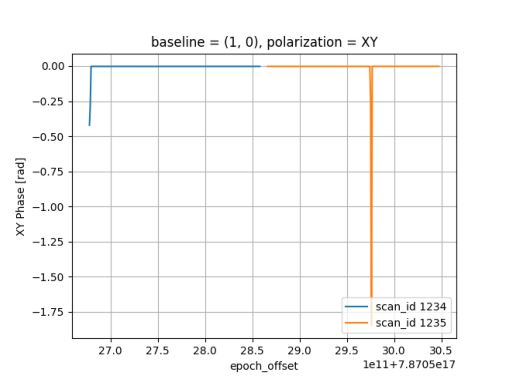

In [66]:
plot = plotting.plot_channel_averaged_phase_vs_time(
    xr.concat(
        [visibility_data_1, visibility_data_2],
        dim=pd.Index([SCAN_ID, SCAN_ID + 1], name="scan_id"),
    ),
    baseline_idx,
    visibilities.Polarization.XY,
)
img = Image.open(BytesIO(plot))
plt.imshow(img, aspect="auto")
plt.axis("off")
plt.show()

### XY time averaged phase vs channel


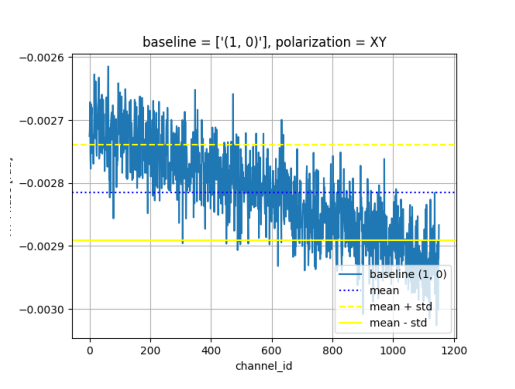

In [67]:
plot = plotting.plot_time_averaged_phase_vs_channel(
    visibility_data_1,
    baseline_idx,
    visibilities.Polarization.XY,
    trim_first_s=5,
)
img = Image.open(BytesIO(plot))
plt.imshow(img, aspect="auto")
plt.axis("off")
plt.show()

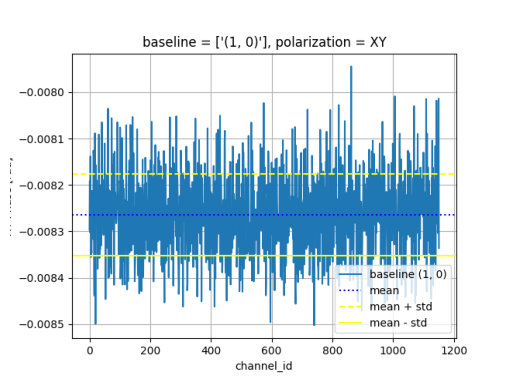

In [68]:
plot = plotting.plot_time_averaged_phase_vs_channel(
    visibility_data_2,
    baseline_idx,
    visibilities.Polarization.XY,
    trim_first_s=5,
)
img = Image.open(BytesIO(plot))
plt.imshow(img, aspect="auto")
plt.axis("off")
plt.show()